***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

DONE loading MixUp Data generator
DONE loading MixUp Data generator


# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = SARUMAN
• Working Directory = D:\knoor\Deep Learning with Python\RunningOnServer\GitHub Repo\HDeep_CapsNet\code\training\Stanford_Cars
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : D:\knoor\AnacondaEnvironment\py38tf28


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "1" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  1
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


# Parameters

In [4]:
train_params = {"n_epochs" : 100,
                "batch_size": 16,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": 'adam',
                "loss_function": models.MarginLoss(),
               }

# Import Dataset : Stanford_Cars

In [5]:
training_dataset,  test_dataset, val_dataset, tree, info = datasets.Stanford_Cars(image_size=(64, 64), 
                                                                                  batch_size=train_params['batch_size'],
                                                                                  data_aug = 'mixup',
                                                                                  data_normalizing = None)

In [6]:
for x,y in training_dataset.take(1):
    image_shape = x.shape[1:]
    coarse_label_shape = y[0].shape[1:]
    medium_label_shape = y[1].shape[1:]
    fine_label_shape = y[2].shape[1:]

In [7]:
from src.models import *

In [8]:
## For Dynamic LossWeights
initial_lw = initial_lw({"coarse": info['Num_Coarse'],
                         "medium": info['Num_Medium'],
                         "fine": info['Num_Fine']})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

## Learning Rate Decay Scheduler

In [9]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Bottom up Approach

## Loss Function

In [10]:
Matrix_coarse_to_medium_OneHot = tf.constant(info['Matrix_coarse_to_medium'], dtype=tf.float32)
Matrix_medium_to_fine_OneHot = tf.constant(info['Matrix_medium_to_fine'], dtype=tf.float32)

In [11]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")

    return total_marginloss


def CustomLoss(y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f, LW_C, LW_M, LW_F,
               number_of_classes_m, number_of_classes_f, C_Weight=0.2):
     
   
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_m = margin_loss(y_true_m, y_pred_m)*LW_M
    ML_f = margin_loss(y_true_f, y_pred_f)*LW_F
    
    batch_loss = ML_c + ML_m+ ML_f

    return tf.reduce_mean(batch_loss)

## Model Architecture

In [12]:
def get_compiled_model():
    input_shape = image_shape

    input_shape_yc = coarse_label_shape
    input_shape_ym = medium_label_shape
    input_shape_yf = fine_label_shape

    no_coarse_class = info['Num_Coarse']
    no_medium_class = info['Num_Medium']
    no_fine_class = info['Num_Fine']

    PCap_n_dims = 8

    SCap_f_dims = 16
    SCap_m_dims = 16
    SCap_c_dims = 16


    # Input image
    x_input = keras.layers.Input(shape=input_shape, name="Input_Image")

    # Input True Labels
    y_c = keras.layers.Input(shape=input_shape_yc, name='input_yc')
    y_m = keras.layers.Input(shape=input_shape_ym, name='input_ym')
    y_f = keras.layers.Input(shape=input_shape_yf, name='input_yf')

    #--- block 1 ---
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(x_input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    #--- block 2 ---
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    #--- block 3 ---
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    #--- block 4 ---
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)


    # Layer 3: Reshape to 8D primary capsules 
    # input [batch_size, 6, 6, 512], output [batch_size, 2304, 8]

    reshape = keras.layers.Reshape((int((tf.reduce_prod(x.shape[1:]).numpy())/PCap_n_dims), PCap_n_dims)
                                   , name="reshape_layer")(x)
    p_caps = keras.layers.Lambda(squash, name='p_caps')(reshape)

    ## Layer Secondary Capsule: For fine level
    s_caps_f = SecondaryCapsule(n_caps=no_fine_class, n_dims=SCap_f_dims, 
                        name="s_caps_fine")(p_caps)

    ## Layer Secondary Capsule: For medium level
    s_caps_m = SecondaryCapsule(n_caps=no_medium_class, n_dims=SCap_f_dims, 
                        name="s_caps_medium")(s_caps_f)

    ## Layer Secondary Capsule: For coarse level
    s_caps_c = SecondaryCapsule(n_caps=no_coarse_class, n_dims=SCap_c_dims, 
                        name="s_caps_coarse")(s_caps_m)

    pred_c = LengthLayer(name='prediction_coarse')(s_caps_c)

    pred_m = LengthLayer(name='prediction_medium')(s_caps_m)

    pred_f = LengthLayer(name='prediction_fine')(s_caps_f)

    model = keras.Model(
        inputs= [x_input, y_c, y_m, y_f],
        outputs= [pred_c, pred_m, pred_f],
        name='HD-CapsNet')
    
    model.add_loss(CustomLoss(y_c, y_m, y_f, pred_c, pred_m, pred_f, 
                              lossweight['coarse_lw'], lossweight['medium_lw'], lossweight['fine_lw'],
                             info['Num_Medium'],info['Num_Fine']))
    
    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_medium': 'accuracy',
                           'prediction_coarse': 'accuracy'
                          }
                 )
    return model

## Compile Model

In [13]:
model = get_compiled_model()

## log directory

In [14]:
directory = sysenv.log_dir('HD_CapsNet/WO_C_loss')

FOLDER CREATED =  ./logs/HD_CapsNet/WO_C_loss


In [15]:
model.summary()
# keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 64, 64, 64)   1792        ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 64, 64, 64)   36928       ['batch_normalization[0]

                                                                                                  
 tf.math.subtract_3 (TFOpLambda  (None, 113)         0           ['prediction_medium[0][0]']      
 )                                                                                                
                                                                                                  
 tf.math.subtract_4 (TFOpLambda  (None, 113)         0           ['prediction_medium[0][0]']      
 )                                                                                                
                                                                                                  
 tf.math.maximum (TFOpLambda)   (None, 13)           0           ['tf.math.subtract[0][0]']       
                                                                                                  
 tf.math.subtract_2 (TFOpLambda  (None, 13)          0           ['input_yc[0][0]']               
 )        

 da)                                                                                              
                                                                                                  
 tf.math.add_2 (TFOpLambda)     (None, 196)          0           ['tf.math.multiply_8[0][0]',     
                                                                  'tf.math.multiply_10[0][0]']    
                                                                                                  
 tf.math.multiply_3 (TFOpLambda  (None,)             0           ['tf.math.reduce_sum[0][0]']     
 )                                                                                                
                                                                                                  
 tf.math.multiply_7 (TFOpLambda  (None,)             0           ['tf.math.reduce_sum_1[0][0]']   
 )                                                                                                
          

## Data Augmentation

## Training Pipeline Alignment

In [16]:
#### Matching the pipeling with model inputs
def pipeline_multi_input_output(image, label):
    label_0 = label[0]
    label_1 = label[1]
    label_2 = label[2]
    return (image, label_0, label_1, label_2), (label_0, label_1, label_2)

training_dataset_match = training_dataset.map(pipeline_multi_input_output) ## Mixup dataset
val_dataset_match = val_dataset.map(pipeline_multi_input_output) ## Val Dataset

## Callback

In [17]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(
    directory+'/weights-{epoch:02d}.h5', 
    monitor='val_prediction_fine_accuracy',
    save_best_only=True, save_weights_only=True, verbose=1)
change_lw = LossWeightsModifier(lossweight = lossweight,
                               initial_lw = initial_lw,
                               directory = directory)
lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [18]:
history = model.fit(training_dataset_match,
                    epochs = train_params["n_epochs"],
                    validation_data = val_dataset_match,
                    callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                    verbose=1)

model_save_dir = str(directory+'/trained_model.h5')
try:
    model.save_weights(model_save_dir)
    print('Trained model saved to = ', model_save_dir)
except:
    print('Model Wight is not saved')

Epoch 1/100
509/509 [==============================] - ETA: 0s - loss: 0.7822 - prediction_coarse_accuracy: 0.1256 - prediction_medium_accuracy: 0.0212 - prediction_fine_accuracy: 0.0301
  • Coarse Accuracy = 12.56% | Val_Accuracy = 15.00% | LossWeight = 0.45 
  • Medium Accuracy = 2.12% | Val_Accuracy = 2.44% | LossWeight = 0.34 
  • Fine   Accuracy = 3.01% | Val_Accuracy = 2.01% | LossWeight = 0.20 

Epoch 1: val_prediction_fine_accuracy improved from -inf to 0.02015, saving model to ./logs/HD_CapsNet/WO_C_loss\weights-01.h5
509/509 [==============================] - 230s 381ms/step - loss: 0.7822 - prediction_coarse_accuracy: 0.1256 - prediction_medium_accuracy: 0.0212 - prediction_fine_accuracy: 0.0301 - val_loss: 0.7795 - val_prediction_coarse_accuracy: 0.1500 - val_prediction_medium_accuracy: 0.0244 - val_prediction_fine_accuracy: 0.0201 - lr: 0.0010
Epoch 2/100
509/509 [==============================] - ETA: 0s - loss: 0.6787 - prediction_coarse_accuracy: 0.2313 - prediction_med

Epoch 10/100
509/509 [==============================] - ETA: 0s - loss: 0.3753 - prediction_coarse_accuracy: 0.6766 - prediction_medium_accuracy: 0.4796 - prediction_fine_accuracy: 0.7619
  • Coarse Accuracy = 67.66% | Val_Accuracy = 43.98% | LossWeight = 0.42 
  • Medium Accuracy = 47.96% | Val_Accuracy = 12.96% | LossWeight = 0.46 
  • Fine   Accuracy = 76.19% | Val_Accuracy = 8.16% | LossWeight = 0.13 

Epoch 10: val_prediction_fine_accuracy did not improve from 0.08557
509/509 [==============================] - 212s 385ms/step - loss: 0.3753 - prediction_coarse_accuracy: 0.6766 - prediction_medium_accuracy: 0.4796 - prediction_fine_accuracy: 0.7619 - val_loss: 0.5381 - val_prediction_coarse_accuracy: 0.4398 - val_prediction_medium_accuracy: 0.1296 - val_prediction_fine_accuracy: 0.0816 - lr: 0.0010
Epoch 11/100
509/509 [==============================] - ETA: 0s - loss: 0.3163 - prediction_coarse_accuracy: 0.7721 - prediction_medium_accuracy: 0.6376 - prediction_fine_accuracy: 0.819

509/509 [==============================] - 213s 386ms/step - loss: 0.1164 - prediction_coarse_accuracy: 0.9665 - prediction_medium_accuracy: 0.9645 - prediction_fine_accuracy: 0.9621 - val_loss: 0.5956 - val_prediction_coarse_accuracy: 0.4356 - val_prediction_medium_accuracy: 0.1435 - val_prediction_fine_accuracy: 0.0948 - lr: 6.3025e-04
Epoch 20/100
509/509 [==============================] - ETA: 0s - loss: 0.1093 - prediction_coarse_accuracy: 0.9677 - prediction_medium_accuracy: 0.9656 - prediction_fine_accuracy: 0.9657
  • Coarse Accuracy = 96.77% | Val_Accuracy = 44.20% | LossWeight = 0.46 
  • Medium Accuracy = 96.56% | Val_Accuracy = 14.53% | LossWeight = 0.33 
  • Fine   Accuracy = 96.57% | Val_Accuracy = 9.48% | LossWeight = 0.20 

Epoch 20: val_prediction_fine_accuracy did not improve from 0.09652
509/509 [==============================] - 213s 387ms/step - loss: 0.1093 - prediction_coarse_accuracy: 0.9677 - prediction_medium_accuracy: 0.9656 - prediction_fine_accuracy: 0.9657

509/509 [==============================] - ETA: 0s - loss: 0.0989 - prediction_coarse_accuracy: 0.9757 - prediction_medium_accuracy: 0.9767 - prediction_fine_accuracy: 0.9752
  • Coarse Accuracy = 97.57% | Val_Accuracy = 42.54% | LossWeight = 0.48 
  • Medium Accuracy = 97.67% | Val_Accuracy = 14.25% | LossWeight = 0.31 
  • Fine   Accuracy = 97.52% | Val_Accuracy = 9.00% | LossWeight = 0.20 

Epoch 29: val_prediction_fine_accuracy did not improve from 0.09652
509/509 [==============================] - 213s 386ms/step - loss: 0.0989 - prediction_coarse_accuracy: 0.9757 - prediction_medium_accuracy: 0.9767 - prediction_fine_accuracy: 0.9752 - val_loss: 0.5947 - val_prediction_coarse_accuracy: 0.4254 - val_prediction_medium_accuracy: 0.1425 - val_prediction_fine_accuracy: 0.0900 - lr: 3.7735e-04
Epoch 30/100
509/509 [==============================] - ETA: 0s - loss: 0.0977 - prediction_coarse_accuracy: 0.9751 - prediction_medium_accuracy: 0.9751 - prediction_fine_accuracy: 0.9756
  • Coa

509/509 [==============================] - 213s 387ms/step - loss: 0.0958 - prediction_coarse_accuracy: 0.9775 - prediction_medium_accuracy: 0.9778 - prediction_fine_accuracy: 0.9772 - val_loss: 0.5936 - val_prediction_coarse_accuracy: 0.4418 - val_prediction_medium_accuracy: 0.1510 - val_prediction_fine_accuracy: 0.0958 - lr: 2.3783e-04
Epoch 39/100
509/509 [==============================] - ETA: 0s - loss: 0.0977 - prediction_coarse_accuracy: 0.9758 - prediction_medium_accuracy: 0.9764 - prediction_fine_accuracy: 0.9761
  • Coarse Accuracy = 97.58% | Val_Accuracy = 43.61% | LossWeight = 0.48 
  • Medium Accuracy = 97.64% | Val_Accuracy = 15.05% | LossWeight = 0.32 
  • Fine   Accuracy = 97.61% | Val_Accuracy = 9.35% | LossWeight = 0.20 

Epoch 39: val_prediction_fine_accuracy did not improve from 0.09652
509/509 [==============================] - 214s 390ms/step - loss: 0.0977 - prediction_coarse_accuracy: 0.9758 - prediction_medium_accuracy: 0.9764 - prediction_fine_accuracy: 0.9761

509/509 [==============================] - ETA: 0s - loss: 0.0968 - prediction_coarse_accuracy: 0.9743 - prediction_medium_accuracy: 0.9734 - prediction_fine_accuracy: 0.9736
  • Coarse Accuracy = 97.43% | Val_Accuracy = 42.79% | LossWeight = 0.47 
  • Medium Accuracy = 97.34% | Val_Accuracy = 14.55% | LossWeight = 0.33 
  • Fine   Accuracy = 97.36% | Val_Accuracy = 9.35% | LossWeight = 0.20 

Epoch 48: val_prediction_fine_accuracy did not improve from 0.09726
509/509 [==============================] - 213s 386ms/step - loss: 0.0968 - prediction_coarse_accuracy: 0.9743 - prediction_medium_accuracy: 0.9734 - prediction_fine_accuracy: 0.9736 - val_loss: 0.5886 - val_prediction_coarse_accuracy: 0.4279 - val_prediction_medium_accuracy: 0.1455 - val_prediction_fine_accuracy: 0.0935 - lr: 1.4240e-04
Epoch 49/100
509/509 [==============================] - ETA: 0s - loss: 0.0944 - prediction_coarse_accuracy: 0.9767 - prediction_medium_accuracy: 0.9784 - prediction_fine_accuracy: 0.9777
  • Coa

509/509 [==============================] - 213s 387ms/step - loss: 0.0945 - prediction_coarse_accuracy: 0.9780 - prediction_medium_accuracy: 0.9779 - prediction_fine_accuracy: 0.9770 - val_loss: 0.5820 - val_prediction_coarse_accuracy: 0.4301 - val_prediction_medium_accuracy: 0.1458 - val_prediction_fine_accuracy: 0.0945 - lr: 8.9745e-05
Epoch 58/100
509/509 [==============================] - ETA: 0s - loss: 0.0930 - prediction_coarse_accuracy: 0.9778 - prediction_medium_accuracy: 0.9784 - prediction_fine_accuracy: 0.9780
  • Coarse Accuracy = 97.78% | Val_Accuracy = 42.84% | LossWeight = 0.49 
  • Medium Accuracy = 97.84% | Val_Accuracy = 14.90% | LossWeight = 0.32 
  • Fine   Accuracy = 97.80% | Val_Accuracy = 9.38% | LossWeight = 0.20 

Epoch 58: val_prediction_fine_accuracy did not improve from 0.09751
509/509 [==============================] - 213s 388ms/step - loss: 0.0930 - prediction_coarse_accuracy: 0.9778 - prediction_medium_accuracy: 0.9784 - prediction_fine_accuracy: 0.9780

509/509 [==============================] - ETA: 0s - loss: 0.0920 - prediction_coarse_accuracy: 0.9778 - prediction_medium_accuracy: 0.9796 - prediction_fine_accuracy: 0.9783
  • Coarse Accuracy = 97.78% | Val_Accuracy = 43.76% | LossWeight = 0.50 
  • Medium Accuracy = 97.96% | Val_Accuracy = 14.78% | LossWeight = 0.31 
  • Fine   Accuracy = 97.83% | Val_Accuracy = 9.45% | LossWeight = 0.20 

Epoch 67: val_prediction_fine_accuracy did not improve from 0.09751
509/509 [==============================] - 213s 387ms/step - loss: 0.0920 - prediction_coarse_accuracy: 0.9778 - prediction_medium_accuracy: 0.9796 - prediction_fine_accuracy: 0.9783 - val_loss: 0.5810 - val_prediction_coarse_accuracy: 0.4376 - val_prediction_medium_accuracy: 0.1478 - val_prediction_fine_accuracy: 0.0945 - lr: 5.3734e-05
Epoch 68/100
509/509 [==============================] - ETA: 0s - loss: 0.0888 - prediction_coarse_accuracy: 0.9792 - prediction_medium_accuracy: 0.9789 - prediction_fine_accuracy: 0.9784
  • Coa

509/509 [==============================] - 215s 390ms/step - loss: 0.0915 - prediction_coarse_accuracy: 0.9789 - prediction_medium_accuracy: 0.9774 - prediction_fine_accuracy: 0.9770 - val_loss: 0.5817 - val_prediction_coarse_accuracy: 0.4381 - val_prediction_medium_accuracy: 0.1527 - val_prediction_fine_accuracy: 0.0970 - lr: 3.3866e-05
Epoch 77/100
509/509 [==============================] - ETA: 0s - loss: 0.0929 - prediction_coarse_accuracy: 0.9821 - prediction_medium_accuracy: 0.9801 - prediction_fine_accuracy: 0.9785
  • Coarse Accuracy = 98.21% | Val_Accuracy = 43.46% | LossWeight = 0.45 
  • Medium Accuracy = 98.01% | Val_Accuracy = 15.15% | LossWeight = 0.34 
  • Fine   Accuracy = 97.85% | Val_Accuracy = 9.68% | LossWeight = 0.22 

Epoch 77: val_prediction_fine_accuracy did not improve from 0.09751
509/509 [==============================] - 216s 390ms/step - loss: 0.0929 - prediction_coarse_accuracy: 0.9821 - prediction_medium_accuracy: 0.9801 - prediction_fine_accuracy: 0.9785

509/509 [==============================] - ETA: 0s - loss: 0.0896 - prediction_coarse_accuracy: 0.9788 - prediction_medium_accuracy: 0.9806 - prediction_fine_accuracy: 0.9796
  • Coarse Accuracy = 97.88% | Val_Accuracy = 43.48% | LossWeight = 0.50 
  • Medium Accuracy = 98.06% | Val_Accuracy = 14.88% | LossWeight = 0.31 
  • Fine   Accuracy = 97.96% | Val_Accuracy = 9.68% | LossWeight = 0.19 

Epoch 86: val_prediction_fine_accuracy did not improve from 0.09751
509/509 [==============================] - 217s 392ms/step - loss: 0.0896 - prediction_coarse_accuracy: 0.9788 - prediction_medium_accuracy: 0.9806 - prediction_fine_accuracy: 0.9796 - val_loss: 0.5819 - val_prediction_coarse_accuracy: 0.4348 - val_prediction_medium_accuracy: 0.1488 - val_prediction_fine_accuracy: 0.0968 - lr: 2.0277e-05
Epoch 87/100
509/509 [==============================] - ETA: 0s - loss: 0.0888 - prediction_coarse_accuracy: 0.9792 - prediction_medium_accuracy: 0.9786 - prediction_fine_accuracy: 0.9775
  • Coa

509/509 [==============================] - 215s 389ms/step - loss: 0.0908 - prediction_coarse_accuracy: 0.9802 - prediction_medium_accuracy: 0.9811 - prediction_fine_accuracy: 0.9792 - val_loss: 0.5787 - val_prediction_coarse_accuracy: 0.4358 - val_prediction_medium_accuracy: 0.1485 - val_prediction_fine_accuracy: 0.0933 - lr: 1.2779e-05
Epoch 96/100
509/509 [==============================] - ETA: 0s - loss: 0.0910 - prediction_coarse_accuracy: 0.9779 - prediction_medium_accuracy: 0.9778 - prediction_fine_accuracy: 0.9779
  • Coarse Accuracy = 97.79% | Val_Accuracy = 43.51% | LossWeight = 0.48 
  • Medium Accuracy = 97.78% | Val_Accuracy = 14.88% | LossWeight = 0.33 
  • Fine   Accuracy = 97.79% | Val_Accuracy = 9.50% | LossWeight = 0.20 

Epoch 96: val_prediction_fine_accuracy did not improve from 0.09751
509/509 [==============================] - 217s 393ms/step - loss: 0.0910 - prediction_coarse_accuracy: 0.9779 - prediction_medium_accuracy: 0.9778 - prediction_fine_accuracy: 0.9779

In [19]:
history_dict = history.history

(0.0, 1.0)

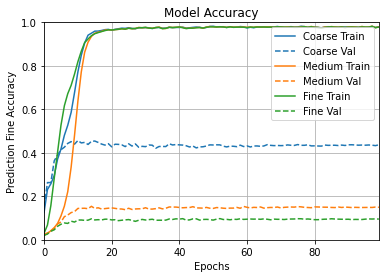

In [20]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
plt.title("Model Accuracy")
plt.ylim([0,1])

(0.0, 1.0)

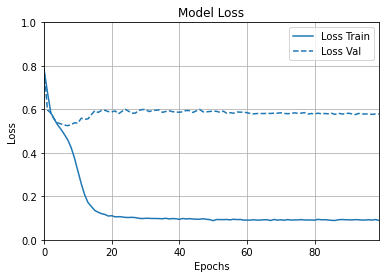

In [21]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Loss": history}, metric = "loss")
plt.title("Model Loss")
plt.ylim([0,1])

## Model Analysis

In [22]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : MarginLoss(),
                          'prediction_medium' : MarginLoss(),
                          'prediction_coarse' : MarginLoss()},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

In [23]:
results = final_model.evaluate(test_dataset)
for n in range(len(results)):
    print(str(n+1)+'.',final_model.metrics_names[n], '==>', results[n])
model_predictions = final_model.predict(test_dataset)

252/252 [==============================] - 31s 113ms/step - loss: 0.5787 - prediction_coarse_loss: 0.5074 - prediction_medium_loss: 0.6221 - prediction_fine_loss: 0.6727 - prediction_coarse_accuracy: 0.4370 - prediction_medium_accuracy: 0.1497 - prediction_fine_accuracy: 0.0952
1. loss ==> 0.5787359476089478
2. prediction_coarse_loss ==> 0.5073924660682678
3. prediction_medium_loss ==> 0.6220584511756897
4. prediction_fine_loss ==> 0.6726604104042053
5. prediction_coarse_accuracy ==> 0.436955988407135
6. prediction_medium_accuracy ==> 0.14971400797367096
7. prediction_fine_accuracy ==> 0.09524993598461151


In [24]:
def predict_from_pipeline(model, dataset):
    y_pred = []
    y_true = []
    image = []
    for x, y in dataset:
        batch_pred = model.predict(x)
        for i in range(len(batch_pred)):
            if i >= len(y_pred):
                y_pred.append(None)
                y_true.append(None)
                image.append(None)
            if y_pred[i] is None:
                y_pred[i] = batch_pred[i]
                y_true[i] = list(y[i].numpy())
                image[i] = list(x[i].numpy())
            else:
                y_pred[i] = np.concatenate([y_pred[i], batch_pred[i]])
                y_true[i] = y_true[i] + list(y[i].numpy())
                image[i] = image[i] + list(x[i].numpy())
    return y_true, y_pred, image

In [25]:
predictions = []
predictions.append(predict_from_pipeline(final_model, test_dataset))

In [26]:
dataset= {'x_test':predictions[0][2][0], 
          'y_test_coarse':predictions[0][0][0], 
          'y_test_medium':predictions[0][0][1], 
          'y_test_fine':predictions[0][0][2]}

In [27]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0][1][0],predictions[0][1][1],predictions[0][1][2]]

  • Confusion_Matrix 

  • COARSE LEVEL 
[[124 114   0   0   0   8   0   0   0 208  41   0   0]
 [ 59 254   0   0   0  10   0   0   0 252  27   1   0]
 [  2   3   0   0   0   0   0   0   0   6   1   1   0]
 [  3   9   0  21   5   0   0   0   1  24 108   1   0]
 [  7   6   0   0  10   2   0   0   3   4  57   4   1]
 [ 30  67   0   0   0  19   0   0   0 139  50   1   0]
 [  3  16   0   1   0   1   1   0   0  24   4   0   0]
 [  8   9   0   0   0   3   0   8   0  83  37   1   1]
 [ 11   1   0   0   5   0   0   0  11   5  46   2   0]
 [ 60 144   0   1   0  11   0   2   0 733 103   0   4]
 [ 19  26   0   8   1   2   0   0   1 148 504   2   3]
 [  5  16   0   1   3   3   0   1   0  22  26  64   0]
 [ 11  14   0   0   0   0   0   0   0  83  27   1   8]]

  • MEDIUM LEVEL 
[[ 4  2  0 ...  0  0  0]
 [ 0 15  0 ...  0  0  1]
 [ 0  0 16 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  1  0]
 [ 0  1  1 ...  0  0  3]]

  • FINE LEVEL 
[[6 0 0 ... 0 0 1]
 [0 1 1 ... 0 2 0]
 [0 1 0 ... 0

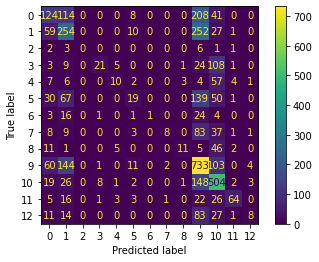

D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0    0.36257   0.25051   0.29630       495
           1    0.37408   0.42123   0.39626       603
           2    0.00000   0.00000   0.00000        13
           3    0.65625   0.12209   0.20588       172
           4    0.41667   0.10638   0.16949        94
           5    0.32203   0.06209   0.10411       306
           6    1.00000   0.02000   0.03922        50
           7    0.72727   0.05333   0.09938       150
           8    0.68750   0.13580   0.22680        81
           9    0.42345   0.69282   0.52564      1058
          10    0.48885   0.70588   0.57765       714
          11    0.82051   0.45390   0.58447       141
          12    0.47059   0.05556   0.09938       144

    accuracy                        0.43696      4021
   macro avg    0.51921   0.23689   0.25574      4021
weighted avg    0.46031   0.43696   0.39029      4021


  • MEDIUM LEVEL 


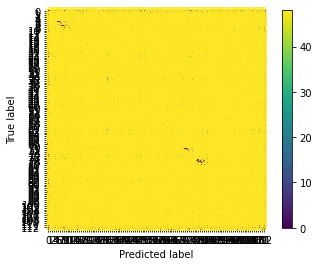

              precision    recall  f1-score   support

           0    0.11111   0.10811   0.10959        37
           1    0.16304   0.17442   0.16854        86
           2    0.28571   0.42105   0.34043        38
           3    0.37500   0.15789   0.22222        19
           4    0.18919   0.16667   0.17722        42
           5    0.13793   0.09756   0.11429        41
           6    0.11628   0.10870   0.11236        46
           7    0.12741   0.33673   0.18487        98
           8    0.13333   0.08696   0.10526        23
           9    0.14516   0.25472   0.18493       106
          10    0.10000   0.05263   0.06897        19
          11    0.20000   0.07692   0.11111        13
          12    0.14286   0.10000   0.11765        40
          13    0.14085   0.16667   0.15267        60
          14    0.09167   0.13924   0.11055        79
          15    0.27586   0.17021   0.21053        47
          16    0.00000   0.00000   0.00000        54
          17    0.21739   0

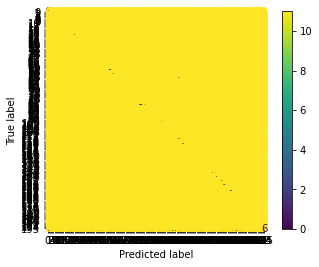

              precision    recall  f1-score   support

           0    0.25000   0.31579   0.27907        19
           1    0.07692   0.05000   0.06061        20
           2    0.00000   0.00000   0.00000        21
           3    0.10000   0.04167   0.05882        24
           4    0.00000   0.00000   0.00000        21
           5    0.07407   0.11111   0.08889        18
           6    0.13043   0.15789   0.14286        19
           7    0.06667   0.09091   0.07692        22
           8    0.00000   0.00000   0.00000        18
           9    0.09091   0.05000   0.06452        20
          10    0.07692   0.08696   0.08163        23
          11    0.00000   0.00000   0.00000        21
          12    0.05000   0.04545   0.04762        22
          13    0.00000   0.00000   0.00000        19
          14    0.21429   0.14286   0.17143        21
          15    0.11111   0.13636   0.12245        22
          16    0.17647   0.15000   0.16216        20
          17    0.04545   0

In [28]:
metrics.lvl_wise_metric(true_label,pred_label)

In [29]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,pred_label,tree)
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.21606151040371382 
Hierarchical Recall = 0.27265191080162476 
Hierarchical F1-Score = 0.23778140950486137 
Consistency =  0.3412086545635414 
Exact Match =  0.06117881124098483
